# ReadMe

Questo notebook si occupa di convertire il dataset in formato NPZ, in modo da renderlo velocemente acquisibile. <br>
Viene fissata una cartella <code>processed_dataset</code> la quale andrá a contenere il dataset rifinito a partire dal contenuto della cartella <code>raw_dataset</code>


In [10]:
import numpy as np
import matplotlib.pyplot as plt

raw_dataset        = "../PocketAnalysis/refined"
processed_dataset  = "processed_data"

## Oggetti costruiti

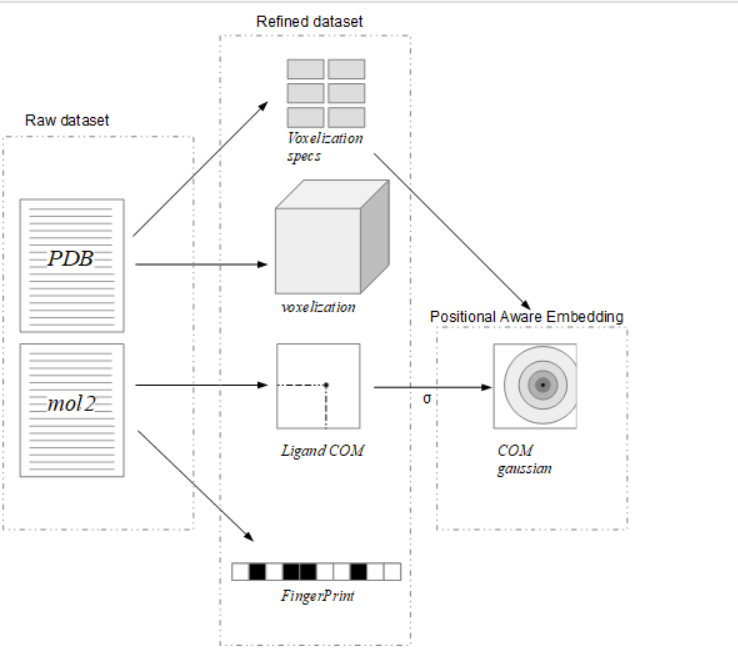

## Conteggio dei samples

In [11]:
import os

samples = 0
for root, dirnames, filenames in os.walk(raw_dataset):
        for dirname in dirnames:
            samples +=1
samples            

1241

## Estrazione della voxelizzazione

In [12]:
def extract_voxelization(filename):
    X = list()                            # coordinate atomiche
    
    file1 = open(filename, 'r')           # leggo il file
    Lines = file1.readlines()             # estraggo le linee
    
    A      = list()                       # coordinate anchor points
    sparse = list()                       # rappresentazione sparsa delle coordinate che descrivono la tasca
    
    x_min,y_min,z_min,x_max,y_max,z_max = 0,0,0,0,0,0
    
    for line in Lines:
        if line.startswith("ANCHOR"):
            A.append(np.array(line.split()[1:]).astype(float))
        if line.startswith("GRIDG"):
            data = np.array(line.split()[2:]).astype(float)
            x_min,y_min,z_min,x_max,y_max,z_max = data[0],data[1],data[2],data[3],data[4],data[5]
        if line.startswith("GRIDVX"):
            coords = np.array(line.split()[1:4]).astype(int)
            if line.split()[-2] == 'P':
                sparse.append(coords)
    
    A      = np.array(A)
    sparse = np.array(sparse).astype(int)
    
    grid = np.zeros( (
        np.max(sparse[:,0])+1,
        np.max(sparse[:,1])+1,
        np.max(sparse[:,2])+1
        )
    )
    
    for s in sparse:
        grid[s[0],s[1],s[2]] = 1.
    
    specs = np.array([x_min,x_max,y_min,y_max,z_min,z_max])
    return grid, specs, A

vox,specs,anchors = extract_voxelization(raw_dataset + r"\1ezq\1ezq_pocket.ligen.pdb")
print("representation...")
#ax = plt.figure().add_subplot(projection = '3d')
#ax.voxels(vox, alpha = 0.1)
print(anchors)
plt.show()

representation...
[[ 6.583  7.571 21.949]
 [ 9.083 -3.929 14.449]
 [ 1.083  3.571 33.949]
 [ 4.083 16.071 20.449]
 [12.083 -6.929 34.449]
 [ 8.083  7.571 13.949]
 [12.083 -8.429 22.449]
 [19.083 -7.929 18.449]
 [17.083 -2.429 10.949]
 [-0.417  8.071 26.449]
 [ 2.583 -2.429 27.449]
 [11.583 -0.929 27.449]
 [-1.417 11.571 34.449]
 [ 8.083 16.571  8.449]
 [10.083  3.071 35.449]
 [13.083  7.071 27.449]
 [-1.417 16.571 27.949]
 [19.583 -3.929 35.449]
 [10.583  2.571  7.949]]


##  Estrazione dei dati relativi al ligando

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator



class AtomicStructure:
    def __init__(self, file_path):
        self.load_periodic_table()
        self.coords_list,self.atom_list = self.get_atom_coordinates_and_types(file_path)
        self.file_path   = file_path
        
    def get_atom_coordinates_and_types(self, filename):
        X = list()                            # coordinate atomiche
        A = list()                            # atom list

        file1 = open(filename, 'r')           # leggo il file
        Lines = file1.readlines()             # estraggo le linee

        reading_atoms = False
        for line in Lines:
            if line.startswith('@<TRIPOS>ATOM'):
                reading_atoms = True
            else:
                if reading_atoms:
                    if line.startswith("@<TRIPOS>BOND"):
                        break
                    else:
                        tokenized = line.split()
                        A.append(tokenized[5].split('.')[0])
                        X.append(tokenized[2:5])

        X = np.array(X).astype(float)
        A = np.array(A)

        return X,A
        
    def compute_center_of_mass(self):
        w = np.array([
                self.atom_weight[atom_type]
            for atom_type in self.atom_list
        ])
        return (w[:,None] * self.coords_list).sum(axis = 0) / w.sum()
    
    def compute_finger_print(self):
        m   = Chem.rdmolfiles.MolFromMol2File(self.file_path)
        fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2)
        fp1 = fpgen.GetFingerprint(m)
        fp1 = np.array([bit for bit in fp1])
        return fp1
    
    def load_periodic_table(self):
        pt = pd.read_csv("periodic_table.csv").to_numpy()
        self.atom_weight = {}
        for atom_data in pt:
            atom_name                   = atom_data[2]
            atom_weight                 = atom_data[3]
            self.atom_weight[atom_name] = atom_weight
    
    def draw(self):     
        size = np.array([
                self.atom_weight[atom_type]
            for atom_type in self.atom_list
        ])
        
        atomi_unici = np.unique(self.atom_list)
        

        ax = plt.figure(figsize =(10,10)).add_subplot(projection = '3d')
        ax.scatter(
            self.coords_list[:,0],
            self.coords_list[:,1],
            self.coords_list[:,2],
            s = size
        )
        
        com = self.compute_center_of_mass()
        ax.scatter(
            com[0],
            com[1],
            com[2],
            color = 'red'
        )
        

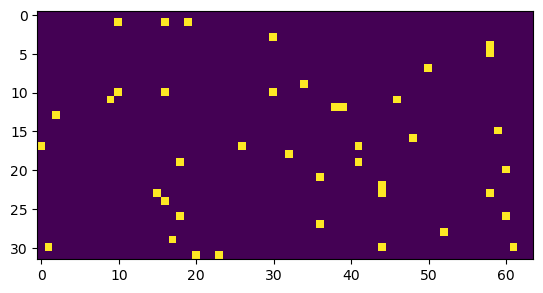

In [14]:
atomic_structure  = AtomicStructure(raw_dataset + "/1a69/1a69_ligand.mol2")
fp                = atomic_structure.compute_finger_print()
plt.imshow( fp.reshape(2**5,2**6) )

## Loop di caricamento dei dati

In [18]:
voxelization_specs  = []    # specifiche delle voxelizzazioni
voxelizations       = []    # contiene le voxelizzazioni
centers_of_mass     = []    # contiene i centri di massa
finger_prints       = []    # contiene le fingerprints
anchors             = []    # contiene la lista delle liste di anchor points

count = 0
N     = 300             # quanti sample caricare dal dataset?


for root, dirnames, filenames in os.walk(raw_dataset):    
        for dirname in dirnames:
            try:
                if count > N:
                    break
                    
                # trovo il path del ligando
                ligand_name       = dirname + "\\" + dirname+"_ligand.mol2"
                whole_ligand_path = "%s\\%s" % (root,ligand_name)
                
                atomic_structure  = AtomicStructure(whole_ligand_path)
                COM               = atomic_structure.compute_center_of_mass()
                finger_print      = atomic_structure.compute_finger_print()
                
                
                # trovo il path della tasca
                pocket_name               = dirname + "\\" + dirname+"_pocket.ligen.pdb"
                whole_pocket_path         = '%s\\%s' % (root,pocket_name)
                vox,vox_specs,anchor      = extract_voxelization(whole_pocket_path)
                
                centers_of_mass.append(COM)
                finger_prints.append(finger_print)
                voxelizations.append(vox)
                voxelization_specs.append(vox_specs)
                anchors.append(anchor)
                count += 1
                
                #if int((count)/(N/ 10)) != int( (count + 1) / (N/ 10) ) :
                print(count)
                
            except KeyboardInterrupt:
                break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


[19:51:27] 1bq4_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301


# Salvataggio in formato NPZ

In [20]:
for ( i, 
    voxelization,
    voxelization_spec,
    center_of_mass, 
    finger_print,
    anchor) in zip(
                                        range(len(voxelizations)),   # enumeratore
                                        voxelizations,               # voxelizzazioni
                                        voxelization_specs,          # specifiche delle voxelizzazioni
                                        centers_of_mass,             # centri di massa
                                        finger_prints,               # finger prints delle molecole
                                        anchors
                                        ):
        
    np.save("%s/voxelizations/voxelization_%d"   % (processed_dataset,i),  np.array(voxelization))
    np.save("%s/voxelization_specs/voxelization_spec_%d"   % (processed_dataset,i),  np.array(voxelization_spec))
    np.save("%s/centers_of_mass/center_of_mass_%d" % (processed_dataset,i),  np.array(center_of_mass))
    np.save("%s/finger_prints/finger_print_%d"          % (processed_dataset,i),  np.array(finger_print))
    np.save("%s/anchors/anchor_%d"          % (processed_dataset,i),  np.array(anchor))

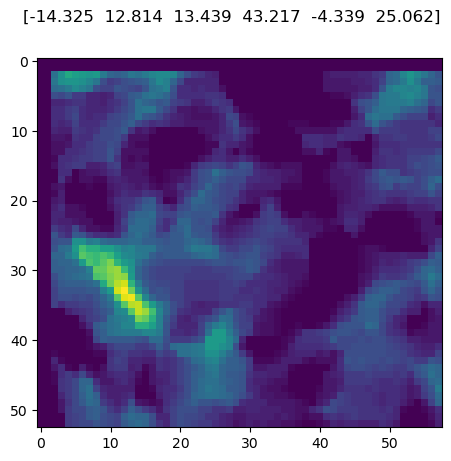

In [144]:
plt.figure()
sample = 47
plt.suptitle("%s" % voxelization_specs[sample])
plt.imshow(voxelizations[sample].mean(axis = 2))

In [24]:

pd.read_csv("periodic_table.csv").to_numpy()[1]

array([2, 'Helium', 'He', 4.002, 2, 2, 2, 1, 18.0, 'gas', nan, 'yes', nan,
       'yes', nan, 'Noble Gas', 0.49, nan, 24.5874, 0.000179, nan, 4.22,
       5.0, 'Janssen', 1868.0, 5.193, 1, nan], dtype=object)